<a href="https://colab.research.google.com/github/E1250/cnn_cv-ref/blob/main/Pix2PixGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Dataset - https://www.kaggle.com/datasets/vikramtiwari/pix2pix-dataset
* Github Project - https://github.com/AhmedIbrahimai/Pix2Pix-GAN-Colab-Paired-Image-to-Image-Translation/blob/main/Pix2PixGAN%20Colab.ipynb
* Lecture Video - https://www.youtube.com/watch?v=hBREOKPFvTo&list=PLyhJeMedQd9TOCgmveCL0debeOQxkP6Vm&index=6

# Pix2PixGAN

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/vikramtiwari/pix2pix-dataset')

## Creating Functions

In [3]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import time

from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization, LeakyReLU, Conv2DTranspose, Dropout, ReLU, Input, Concatenate, ZeroPadding2D
from keras.optimizers import Adam
from keras.utils import plot_model

In [4]:
devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(devices[0] ,enable=True)
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
BATCH_SIZE = 1
IMAGE_SIZE = 256

In [6]:
def load(image_file):
    image = tf.io.read_file(image_file) # Reading the image using TF
    image = tf.image.decode_jpeg(image, channels=3)  # Decoding the image

    w = tf.shape(image)[1] // 2 # Splitting the image to get the right, left part
    real_image = image[:, :w, :] # Real Image (Left)
    input_image = image[:, w:, :] # Segmented Image (Right)

    # Converting to Float
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

In [7]:
# Checking the shapes
x,y = load('/content/pix2pix-dataset/cityscapes/cityscapes/train/1.jpg')
print(x.shape, y.shape) # Done

(256, 256, 3) (256, 256, 3)


(-0.5, 255.5, 255.5, -0.5)

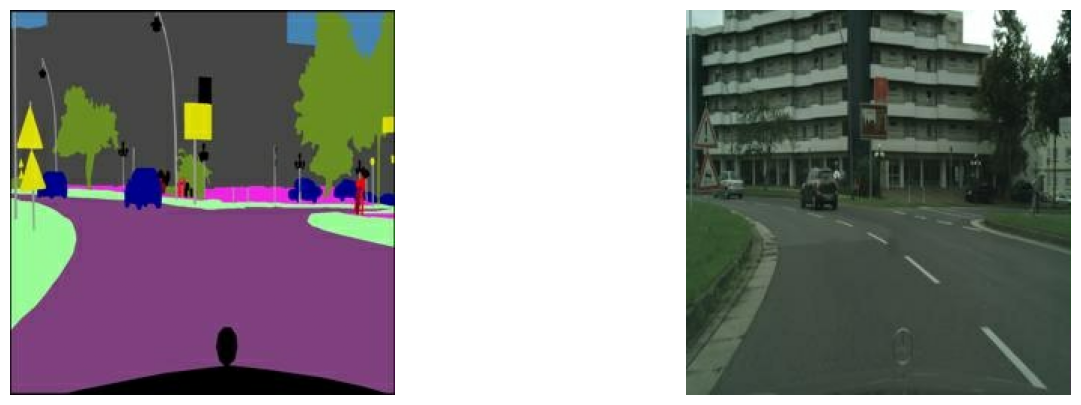

In [8]:
# visualize the two parts (Splits)
fig, axes = plt.subplots(1,2, figsize = (16,5))

axes[0].imshow(x/255.0) # Normalizing first
axes[0].axis('off')

axes[1].imshow(y/255.0)
axes[1].axis('off')

In [9]:
def normalize(input_image, real_image):
  """Normalizing our Data"""
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [10]:
def resize(input_image, real_image):
    input_image = tf.image.resize(input_image, [IMAGE_SIZE, IMAGE_SIZE], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [IMAGE_SIZE, IMAGE_SIZE], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

In [11]:
def random_jitter(input_image, real_image):
  # Flipping our images
  input_image = tf.image.flip_left_right(input_image)
  real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

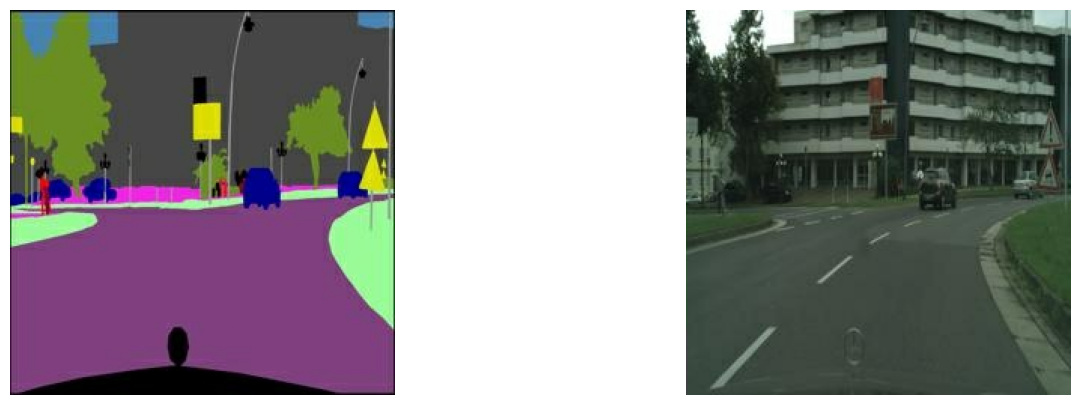

In [12]:
# Visualiaing Flipping
x_jit, y_jit = random_jitter(x, y)
fig, axes = plt.subplots(1,2, figsize = (16,5))
axes[0].imshow(x_jit/255.0)
axes[0].axis('off')
axes[1].imshow(y_jit/255.0)
axes[1].axis('off');

In [13]:
# Combining all Preprocessing in one function
def load_train_images(image_path):
  input_image, real_image = load(image_path)
  input_image, real_image = resize(input_image, real_image)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image,real_image

In [14]:
def load_test_image(image_path):
    input_image, real_image = load(image_path)
    input_image, real_image = resize(input_image, real_image)
    # No Random Flipping in test data
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [15]:
# Create input pipeline
train_dataset = tf.data.Dataset.list_files("/content/pix2pix-dataset/cityscapes/cityscapes/train/*.jpg")
train_dataset = train_dataset.map(load_train_images) # Applying function on our images
train_dataset = train_dataset.shuffle(10).batch(BATCH_SIZE)
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

In [16]:
len(train_dataset) # number of batch = number of images in the data cause each image consider batch

2975

In [17]:
test_dataset = tf.data.Dataset.list_files("/content/pix2pix-dataset/cityscapes/cityscapes/val/*.jpg")
test_dataset = test_dataset.map(load_test_image)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

In [18]:
# Downsampling Block
def downsample(filters, size, batchnorm = True):
  # Creating Inits
  init = tf.random_normal_initializer(0.,0.02)

  # Creating the model
  result = Sequential()
  result.add(Conv2D(filters, size, strides = 2, padding = "same", kernel_initializer = init, use_bias = False))
  if batchnorm == True:
      result.add(BatchNormalization())

  # Activation Function
  result.add(LeakyReLU())

  return result

down_model = downsample(3,4)(tf.expand_dims(x, axis = 0))
print(down_model.shape)

(1, 128, 128, 3)


In [19]:
# Upsampling Block
def upsample(filters, size, dropout = False):
  # Create Inits
  init = tf.random_normal_initializer(0, 0.02)

  # Creating the model
  result = Sequential()
  result.add(Conv2DTranspose(filters, size, strides = 2, padding = "same", kernel_initializer = init, use_bias = False))
  result.add(BatchNormalization())
  if dropout == True:
      result.add(Dropout(0.5))

  # Activation Fucntion
  result.add(ReLU())

  return result

up_model = upsample(3,4)(down_model)
print(up_model.shape)

(1, 256, 256, 3)


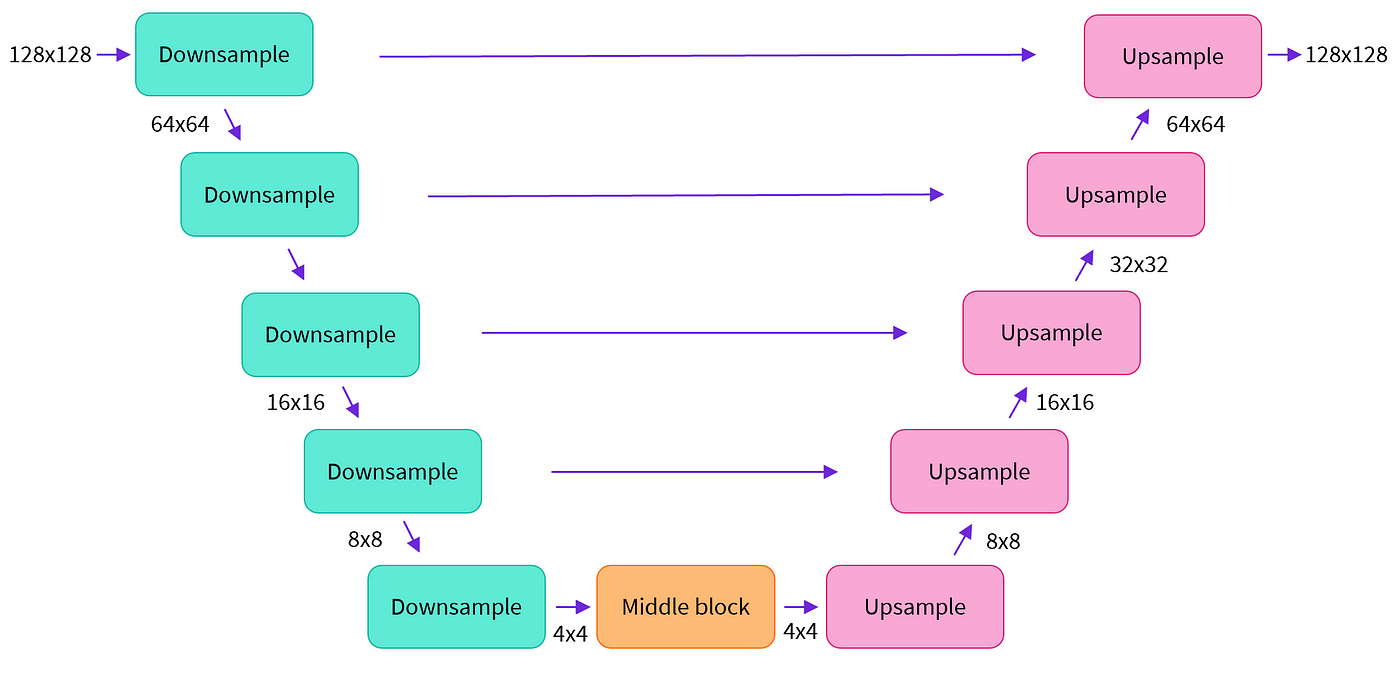

In [20]:
# Creating the Generator
def generator():
    inputs = Input(shape = [IMAGE_SIZE, IMAGE_SIZE, 3])
    down_stack = [
        # 8 According to the paper
        downsample(64, 4, batchnorm = False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4)
    ]

    up_stack = [
        # 7 According to the paper
        upsample(512, 4, dropout = True),
        upsample(512, 4, dropout = True),
        upsample(512, 4),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    init = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(3, 4, strides = 2, padding = "same", kernel_initializer = init, activation ="tanh")

   # Downsampling
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    # Reversing for reconnecting with UpSampling (Look at the pic)
    skips = reversed(skips[:-1])

    # Upsampling
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip]) # Concatenating (Up with Down)

    x = last(x)

    return Model(inputs = inputs, outputs = x)

In [21]:
gen = generator()
gen.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential_2 (Sequential)   (None, 128, 128, 64)         3072      ['input_1[0][0]']             
                                                                                                  
 sequential_3 (Sequential)   (None, 64, 64, 128)          131584    ['sequential_2[0][0]']        
                                                                                                  
 sequential_4 (Sequential)   (None, 32, 32, 256)          525312    ['sequential_3[0][0]']        
                                                                                              

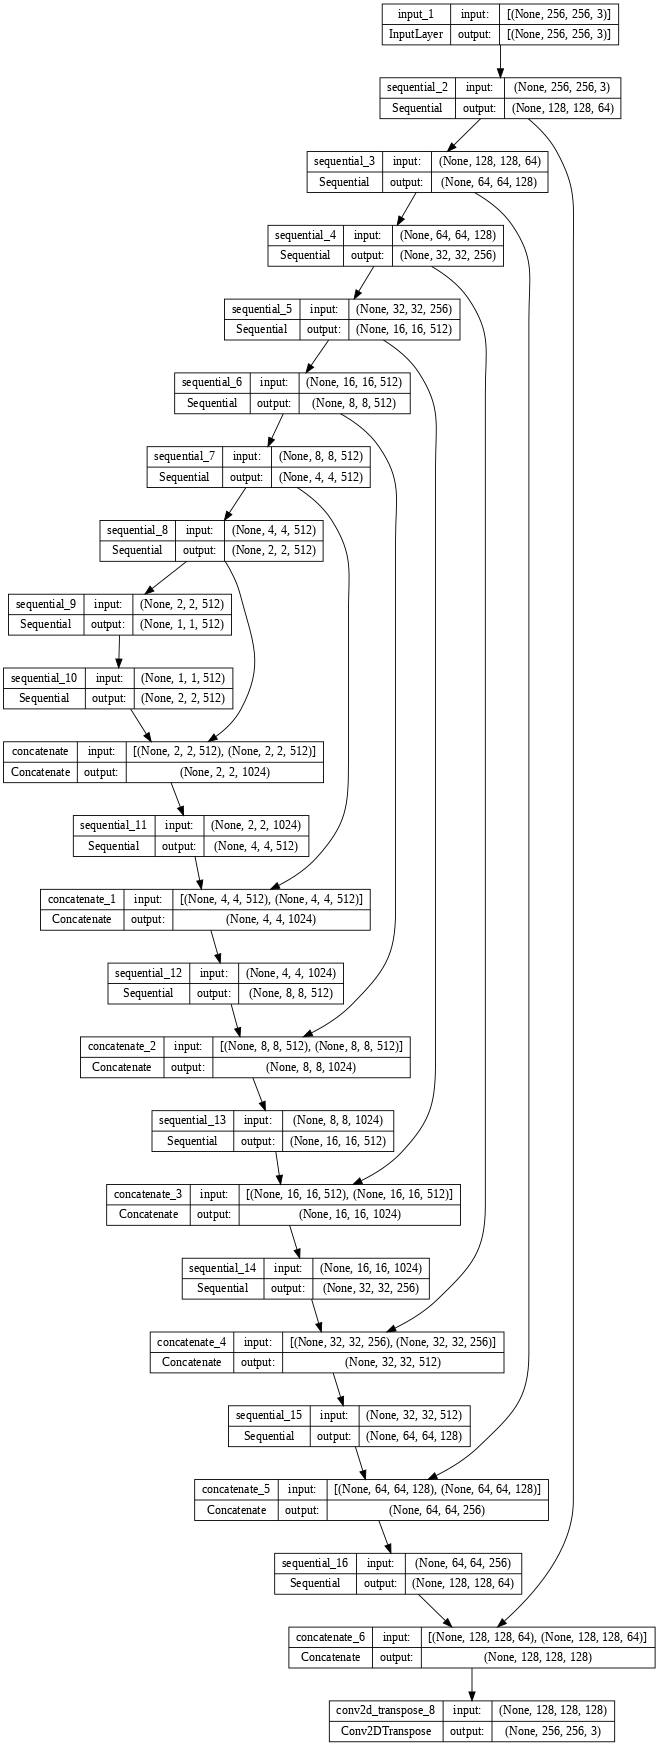

In [22]:
plot_model(gen, show_shapes=True, dpi = 64) # Depth per Inch

In [23]:
LAMBDA = 100

In [24]:
from keras.losses import BinaryCrossentropy

loss_function = BinaryCrossentropy(from_logits=True)

In [25]:
def generator_loss(disc_generated_output, gen_output, target):
  # Losses as paper
  gan_loss = loss_function(tf.ones_like(disc_generated_output), disc_generated_output) # Loss of the Generator
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output)) # Loss of Output of the Generator
  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

Inputs of the Discriminator are these combined images, and the output of the generator combined with this segmented image too.

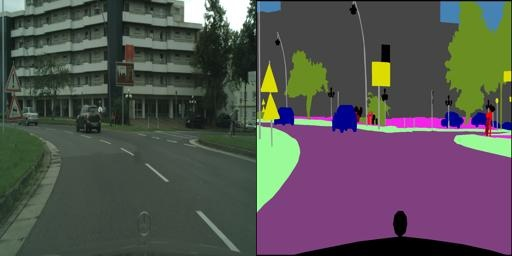

In [27]:
# Discriminator
def discriminator():
  # Paper Architecture

  init = tf.random_normal_initializer(0., 0.02)

  inp = Input(shape = [IMAGE_SIZE, IMAGE_SIZE, 3], name = "input_image")
  tar = Input(shape = [IMAGE_SIZE, IMAGE_SIZE, 3], name = "target_image")
  x = Concatenate()([inp, tar])

  down1 = downsample(64, 4, False)(x)
  down2 = downsample(128, 4)(down1)
  down3 = downsample(256, 4)(down2)

  zero_pad1 = ZeroPadding2D()(down3)
  conv = Conv2D(256, 4, strides = 1, kernel_initializer = init, use_bias = False)(zero_pad1)

  # Activation Function
  leaky_relu = LeakyReLU()(conv)

  zero_pad2 = ZeroPadding2D()(leaky_relu)
  last = Conv2D(1, 4, strides = 1, kernel_initializer = init)(zero_pad2)

  return Model(inputs = [inp, tar], outputs = last)

In [28]:
disc = discriminator()
disc.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 target_image (InputLayer)   [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 concatenate_7 (Concatenate  (None, 256, 256, 6)          0         ['input_image[0][0]',         
 )                                                                   'target_image[0][0]']        
                                                                                                  
 sequential_17 (Sequential)  (None, 128, 128, 64)         6144      ['concatenate_7[0][0]'] 

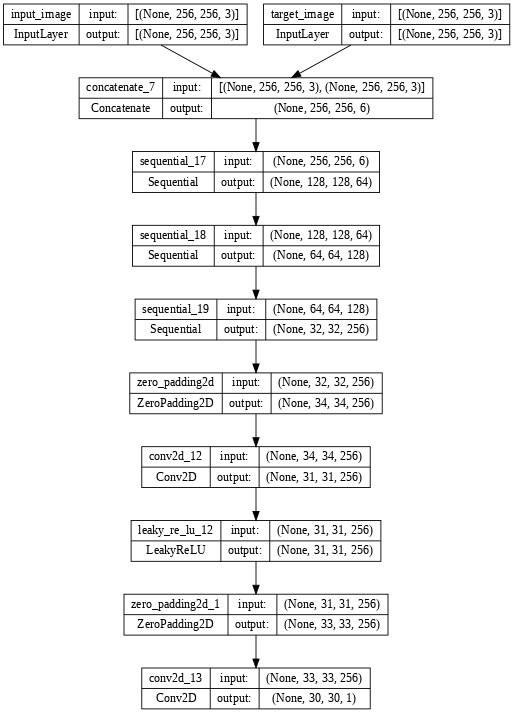

In [29]:
plot_model(disc, show_shapes=True, dpi = 64)

In [30]:
def discriminator_loss(disc_real_output, disc_generated_output):

  real_loss = loss_function(tf.ones_like(disc_real_output), disc_real_output)
  generated_loss = loss_function(tf.zeros_like(disc_generated_output), disc_generated_output) # Loss of output of the generator
  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [32]:
generator_optimizer = Adam(learning_rate= 2e-4, beta_1=0.5)
discriminator_optimizer = Adam(learning_rate = 2e-4, beta_1=0.5)

In [33]:
# Creating outputs directory if not exists.
if not os.path.exists("output"):
    os.mkdir("output")

# Here we are trying to visualize to see the results per epoch.
def save_images(model, test_input, target, epoch):
  prediction = model(test_input, training= True)

  display_list= [test_input[0], target[0], prediction[0]]
  title = ["Input Image", "Ground Truth", "Predicton Image"]

  plt.figure(figsize = (15,15))
  for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis("off")

  plt.savefig(f"output/epoch_{epoch}.jpg")
  plt.close()

In [34]:
epochs = 50

In [35]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = gen(input_image, training = True)

        # Forward Pass (predicting)
        disc_real_output = disc([input_image, target], training = True)
        disc_generated_output = disc([input_image, gen_output], training = True)

        # Calculating the Loss
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        # Calculating Gradients
        generator_gradients = gen_tape.gradient(gen_total_loss, gen.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, disc.trainable_variables)

        # Applying Gradients (step)
        generator_optimizer.apply_gradients(zip(generator_gradients, gen.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, disc.trainable_variables))

        return gen_total_loss, disc_loss

In [36]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):

    start = time.time()
    for input_, target in test_ds.take(1):
        save_images(gen, input_, target, epoch)

    # Training
    print(f"Epoch {epoch}")
    for n, (input_, target) in train_ds.enumerate():
        gen_loss, disc_loss = train_step(input_, target, epoch)

    print("Generator loss {:.2f} Discriminator loss {:.2f}".format(gen_loss, disc_loss))
    print("Time take for epoch {} is {} sec\n".format(epoch+1, time.time() - start))

In [37]:
import keras

# Clearing our GPU
keras.backend.clear_session()

In [ ]:
# The outputs are in `output` folder
fit(train_dataset, epochs, test_dataset)

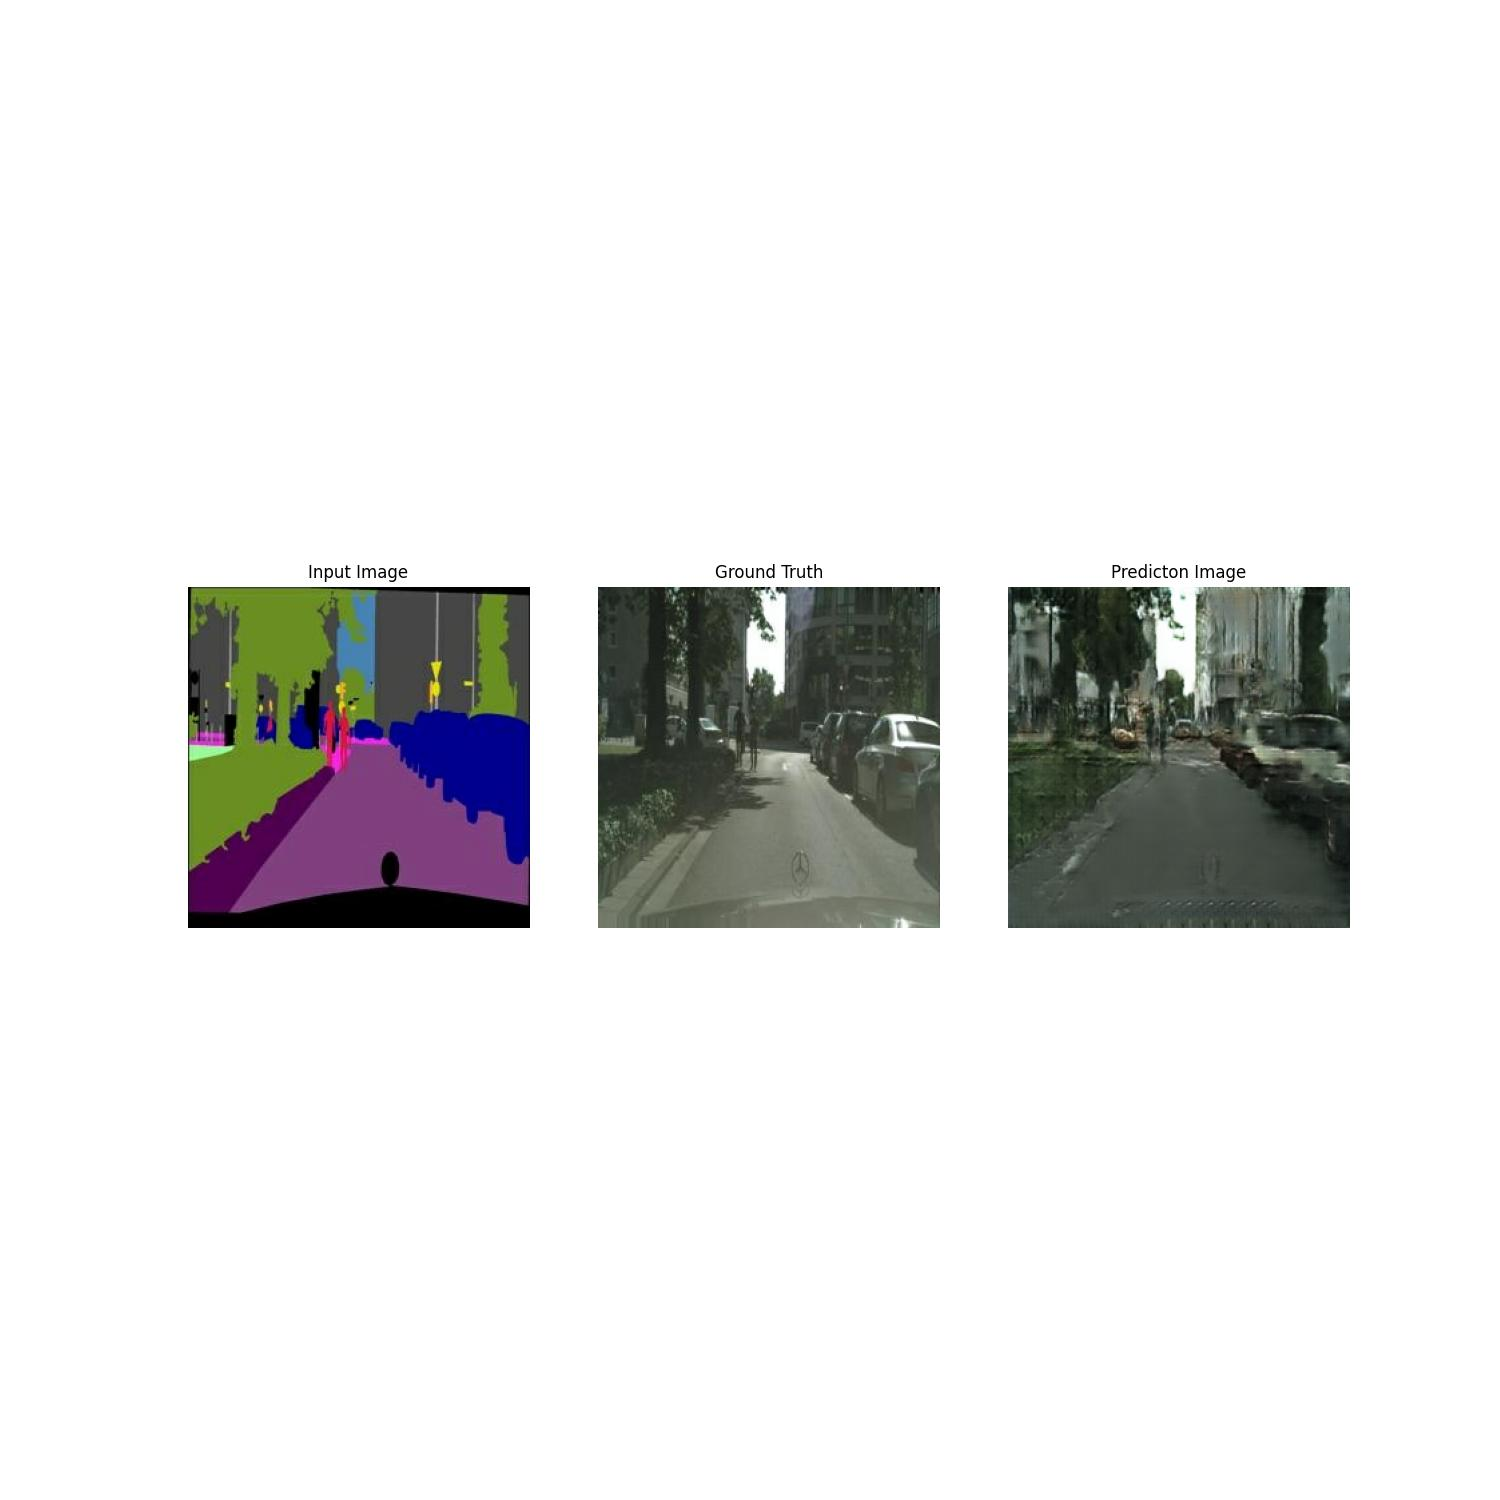

In [39]:
from PIL import Image
Image.open('/content/output/epoch_12.jpg')